# 🏃‍♂️ 🌦️ Berlin Marathon Performance

#### by Scott Macalister


## 📌 Research Question

#### How do weather conditions affect performance at the Berlin Marathon?

## 📊 Dataset

#### Based on an anonymised register of Berlin marathon runners' finishing times between 1974 and 2019 and a register of the weather conditions during marathon race days.

### Step One: Import the relevant libraries

In [3]:
import pandas as pd

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", category=pd.errors.DtypeWarning)


import scipy.stats as st

### Step Two: Clean the Marathon Dataset

In [5]:
# Import the dataset

In [6]:
marathon = pd.read_csv('marathon_data.csv')

In [7]:
# Check the shape and a random sample of the dataset.

In [8]:
marathon.shape

(884944, 5)

In [9]:
marathon.sample(10)

,YEAR,COUNTRY,GENDER,AGE,TIME
85472,1990,NaN,male,20,03:20:00
34592,1986,NaN,male,35,03:30:00
439683,2007,NaN,male,30,03:38:20
694330,2014,NaN,male,50.0,04:35:11
60451,1988,NaN,male,20,03:37:00
861028,2019,BEL,male,45.0,03:26:26
199525,1998,NaN,female,20,03:01:54
243493,2000,NaN,male,30,03:36:36
411368,2006,NaN,female,20,03:54:44
96605,1990,NaN,male,40,04:06:00


In [10]:
# Clean the 'YEAR' column.

In [11]:
# Print out the years for which we have data.

In [12]:
print(marathon["YEAR"].value_counts().sort_index())

YEAR
1974      244
1975      233
1976      311
1977      230
1979      222
1981     2561
1982     3448
1983     4841
1984     7297
1985     9810
1986    11448
1987    12673
1988    13116
1989    13382
1990    20248
1991    14759
1992    13138
1993    14102
1994    12263
1995    13086
1996    15934
1997    14982
1998    21004
1999    19129
2000    22879
2001    25792
2002    25286
2003    30709
2004    28022
2005    30373
2006    30182
2007    32486
2008    35732
2009    35015
2010    34001
2011    32914
2012    34270
2013    36473
2014    28945
2015    36753
2016    35991
2017    39223
2018    40641
2019    30796
Name: count, dtype: int64


In [13]:
# Which years are missing?

In [14]:
all_years = range(marathon["YEAR"].min(), marathon["YEAR"].max() + 1)

missing_years = set(all_years) - set(marathon["YEAR"].unique())

print(missing_years)

{1978, 1980}


In [15]:
# Here we can see that data is missing from the years 1978 and 1980.
# My first thought was that the Marathon wasn't held during these years, but that proved not to be the case.
# Then I thought perhaps the weather data was missing, but this also wasn't true.
# This data is avalible on the Official Berlin Marathon website.
# For future projects, I could use BeautifulSoup to scrape not only this missing data, but also the Marathons run since 2019.
# For now I will leave these years out of my project.

In [16]:
# Clean the 'COUNTRY' column.

In [17]:
# I noticed in my sample that 9 of the 10 values were NaN, so it makes sense to check this first.

In [18]:
marathon["COUNTRY"].isna().sum()

854148

In [19]:
NaN_COUNTRY = 854148 / len(marathon["COUNTRY"]) * 100

In [20]:
NaN_COUNTRY

96.52000578567683

In [21]:
# The NaN percentage is extremely high (only data from 2019), so I will just drop this column.

In [22]:
marathon.drop(columns=["COUNTRY"], inplace=True)

In [23]:
marathon.head()

,YEAR,GENDER,AGE,TIME
0,1974,male,L1,02:44:53
1,1974,male,L2,02:46:43
2,1974,male,L2,02:48:08
3,1974,male,L,02:48:40
4,1974,male,L1,02:49:01


In [24]:
# Clean the 'AGE' column.

In [25]:
marathon["AGE"].value_counts()

AGE
40     93608
35     88567
20     83745
45     76964
30     75050
40     68135
45     63539
35     56380
50     49426
50     46897
30     45074
20     36873
55     24504
55     23081
60     11454
60     10669
65      4660
18      4493
65      3659
70      1500
18      1110
70      1064
75       437
A        235
75       184
L1       152
L        131
L2       106
80        80
B         56
M0        50
M         50
BM        39
L3        31
80        30
L4        16
DH        15
C         15
DA         8
D2         5
D3         5
D1         4
DB         2
M<         1
DJ         1
Ber        1
Name: count, dtype: int64

In [26]:
# The data is already formatted in terms of age brackets.

In [27]:
# Check NaNs

In [28]:
marathon["AGE"].isna().sum()

12838

In [29]:
12838 / len(marathon["AGE"]) * 100

1.4507132654721655

In [30]:
# This is an acceptable level to work with.

In [31]:
# First want to take care of these non-numeric values (e.g. L1, DA...)

In [32]:
# These non-numeric values comes from the early years of the Berlin Marathon.¶
# I wasn't able to find precise definitions of these terms online.
# I found that the winner of the inaugral Berlin Marathon, Günter Hallas, was 32 years old at the time and belonged to the L1 age bracket.
# The third place runner, Günter Olbrich, was 41 and belonged to the L2 bracket.
# From this data, I inferred that L = 20-30, L1 = 30-40, L2 = 40-50, L3 = 50-60, and L4 = 60-70
# I'll make another assumption that D stands for Dame (i.e. Women) and has the corresponding age brackets.
# Then, there are other brackets which were introduced from 1976 onwards.
# I found that the 1976 winner, Ingo Sensburg, was 27 years old at the time and in the A age bracket.
# Thus, I infer that A = 20-30, B = 30-40, C = 40-50, M = 50-60.
# Now, there's another problem in that these labels cover two brackets (e.g. B should really belong to 30 and 35).
# I considered splitting these 50:50 into each bracket, but given that this is a fraction of the dataset, I decided just to but them in the higher of each bracket.

In [33]:
# Mapping these new brackets.

In [34]:
AGE_map = {
    'L': '25',
    'L1': '35',
    'L2': '45',
    'L3': '55',
    'L4': '65',
    'D1': '35',
    'D2': '45',
    'D3': '55',
    'D4': '65',
    'A': '25',
    'B': '35',
    'C': '45',
    'M': '55'
}

In [35]:
marathon['AGE'] = marathon['AGE'].replace(AGE_map)

In [36]:
marathon['AGE'].value_counts()

AGE
40     93608
35     88779
20     83745
45     77090
30     75050
40     68135
45     63539
35     56380
50     49426
50     46897
30     45074
20     36873
55     24504
55     23167
60     11454
60     10669
65      4660
18      4493
65      3675
70      1500
18      1110
70      1064
75       437
25       366
75       184
80        80
M0        50
BM        39
80        30
DH        15
DA         8
DB         2
M<         1
Ber        1
DJ         1
Name: count, dtype: int64

In [37]:
# All remaining non-numeric data I will transform into NaNs.

In [38]:
NaN_AGE = ['M0', 'BM', 'DH', 'DA', 'DB', 'M<', 'Ber', 'DJ']

In [39]:
marathon['AGE'] = marathon['AGE'].replace(NaN_AGE, np.nan)

In [40]:
marathon['AGE'].value_counts()

AGE
40    93608
35    88779
20    83745
45    77090
30    75050
40    68135
45    63539
35    56380
50    49426
50    46897
30    45074
20    36873
55    24504
55    23167
60    11454
60    10669
65     4660
18     4493
65     3675
70     1500
18     1110
70     1064
75      437
25      366
75      184
80       80
80       30
Name: count, dtype: int64

In [41]:
# Here I prove that these NaNs are not significant, as they represent only 1/10000 of the dataset. 

In [42]:
marathon["AGE"].isna().sum()

12955

In [43]:
12955 / len(marathon["AGE"]) * 100

1.463934441049377

In [44]:
# Next thing to clean is the duplicate entries (e.g. 40 appearing twice).
# I suspect that this due to mixed data types.
# I've chosen to convert everything to strings, as these make it easier to work with NaNs.

In [45]:
marathon['AGE'] = marathon['AGE'].astype(float)

In [46]:
marathon['AGE'].value_counts().sort_index()

AGE
18.0      5603
20.0    120618
25.0       366
30.0    120124
35.0    145159
40.0    161743
45.0    140629
50.0     96323
55.0     47671
60.0     22123
65.0      8335
70.0      2564
75.0       621
80.0       110
Name: count, dtype: int64

In [47]:
# Clean the 'TIME' column.

In [48]:
marathon["TIME"].value_counts()

TIME
no time     2405
03:29:00    1393
03:27:00    1250
03:28:00    1247
03:43:00    1240
            ... 
06:47:25       1
06:46:14       1
06:44:28       1
06:42:31       1
07:26:09       1
Name: count, Length: 16232, dtype: int64

In [49]:
# Calculate the percentage represented by 'no time'.

In [50]:
2405 / len(marathon["AGE"]) * 100

0.27176860908712863

In [51]:
# 'no time' probably refers to DNF ('Did Not Finish'), but this seems far too low given the size of the dataset.
# Need to investigate this further.

In [52]:
# Here I check 'no time' by year.

In [53]:
NO_TIME = marathon[marathon['TIME'] == 'no time']

In [54]:
NO_TIME["YEAR"].value_counts().sort_index()

YEAR
1977       2
1981      15
1984       3
1985       8
1987       2
1988     274
1989      45
1990       2
1991       2
1992    1325
1993       1
1994     337
1995     386
1996       2
1998       1
Name: count, dtype: int64

In [55]:
# Now to find which years aren't represented.

In [56]:
marathon_years = set(marathon["YEAR"].unique())
DNF_years = set(NO_TIME["YEAR"].unique())

missing_years_DNF = marathon_years - DNF_years

print(missing_years_DNF)
len(missing_years_DNF)

{1974, 1975, 1976, 1979, 1982, 1983, 1986, 1997, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019}


29

In [57]:
# As i suspected, the info related to 'no time' is incomplete, with no data from 29 years.
# DNFs are also expected to be normally distributed, but the value spread within the data we have makes no sense.
# Further research showed that over 20,000 people ran the Berlin Marathon in 1998; the idea that only one person didn't finish is risible.
# So, I am going to drop these values and treat the dataset as 'Finishers Only'.

In [58]:
marathon = marathon[marathon['TIME'] != 'no time']

In [59]:
marathon["TIME"].value_counts()

TIME
03:29:00    1393
03:27:00    1250
03:28:00    1247
03:43:00    1240
03:39:00    1171
            ... 
06:47:25       1
06:46:14       1
06:44:28       1
06:42:31       1
07:26:09       1
Name: count, Length: 16231, dtype: int64

In [60]:
marathon["TIME"].describe()

count       882539
unique       16231
top       03:29:00
freq          1393
Name: TIME, dtype: object

In [61]:
marathon['TIME'].isna().sum()

0

In [62]:
marathon['TIME'].min()

'02:01:39'

In [63]:
marathon['TIME'].max()

'09:49:41'

In [64]:
# looks like this part has been cleaned alredy actually -- looking at results from 1981 (on the official website) i see 154:28:00 + 109:40:00
# so looks tidy, values are in a range i'd expect ...

# might need to clean these outliers -- cut of time of 6hr right ?

### Step Three: Clean the Weather Dataset

In [66]:
weather = pd.read_csv('weather_data.csv')

In [67]:
weather.shape

(46, 8)

In [68]:
weather.head(5)

,YEAR,PRECIP_mm,SUNSHINE_hrs,CLOUD_hrs,ATMOS_PRESS_mbar,AVG_TEMP_C,MAX_TEMP_C,MIN_TEMP_C
0,1974,0.0,0.2,7.0,1009.5,5.4,8.8,1.1
1,1975,4.2,9.4,3.0,1011.4,14.3,20.1,9.5
2,1976,3.0,10.2,3.3,1010.4,12.8,18.0,7.3
3,1977,11.2,0.0,8.0,1013.1,9.7,12.5,7.4
4,1978,1.8,2.7,6.0,1000.6,11.2,14.5,9.4


In [69]:
# as above, i may as well drop years 1978 + 1980

In [70]:
weather = weather[(weather['YEAR'] != 1978) & (weather['YEAR'] != 1980)]

In [71]:
# check for null values

In [72]:
weather.isnull().sum()

YEAR                0
PRECIP_mm           0
SUNSHINE_hrs        0
CLOUD_hrs           0
ATMOS_PRESS_mbar    0
AVG_TEMP_C          0
MAX_TEMP_C          0
MIN_TEMP_C          0
dtype: int64

In [73]:
weather.describe().T

,count,mean,std,min,25%,50%,75%,max
YEAR,44.0,1997.295455,13.176052,1974.00,1986.750,1997.50,2008.250,2019.0
PRECIP_mm,44.0,2.025000,5.113781,0.00,0.000,0.00,0.825,29.8
SUNSHINE_hrs,44.0,5.592955,4.562156,0.00,0.675,6.95,9.950,11.4
CLOUD_hrs,44.0,4.540909,2.662602,0.10,2.000,5.00,7.075,8.0
ATMOS_PRESS_mbar,44.0,1009.834545,7.995606,993.62,1005.725,1010.35,1013.890,1026.8
AVG_TEMP_C,44.0,12.802273,2.663490,5.40,11.025,12.90,14.325,19.4
MAX_TEMP_C,44.0,18.111364,3.849084,8.80,15.400,17.85,20.525,27.6
MIN_TEMP_C,44.0,8.381818,3.118980,1.10,5.850,8.65,10.725,14.8


In [74]:
# In order to better work with the data, going to convert it from numerical to catergorical data.
# I will define 3 labels: 

# Rain: 0 mm = "No Rain", 1-10 mm = "Light Rain", 11-20 mm = "Moderate Rain", 21+ mm = "Heavy Rain".
# Clouds: 0-2 hrs = "Light Clouds", 3-4 hrs = "Moderate Clouds", 5+ hrs = "Heavy Clouds".
# Temperature: 5-10°C = "Cold", 10-15°C = "Warm", 15-20°C = "Hot".

# Atmosphere pressure I will discard as its mainly related to whether the weather is rainy or not, can instead use PRECIP.
# Max and min temp I will discard for convience and use average temperature.

# Probably if i was doing machine learning on the dataset I would probably discard these buckets.

In [75]:
# Now I can have an in-depth look at my most important columns:
# PRECIP_mm, CLOUD_hrs, AVG_TEMP_C

In [76]:
weather['PRECIP_mm'].sort_values().unique()

array([ 0. ,  0.1,  0.3,  0.5,  0.6,  0.7,  1.2,  3. ,  3.9,  4.2,  4.5,
        7. ,  8. ,  9.8, 11.2, 29.8])

In [77]:
weather['CLOUD_hrs'].sort_values().unique()

array([0.1, 0.3, 0.6, 0.8, 1. , 1.4, 1.6, 2. , 2.2, 2.3, 3. , 3.3, 4.3,
       4.5, 4.7, 5. , 5.6, 5.7, 6.3, 6.5, 6.8, 7. , 7.3, 7.5, 7.8, 8. ])

In [78]:
weather['AVG_TEMP_C'].sort_values().unique()

array([ 5.4,  8.4,  8.9,  9.7, 10. , 10.1, 10.3, 10.5, 10.8, 11.1, 11.2,
       11.3, 11.5, 11.7, 12. , 12.4, 12.6, 12.7, 12.8, 13. , 13.1, 13.6,
       13.8, 13.9, 14. , 14.2, 14.3, 14.4, 14.5, 14.9, 15.1, 15.2, 15.8,
       16.3, 16.8, 17.6, 19.4])

In [79]:
# All looking good, so will now create some functions to bring this into a new dataframe, while preserving the year.

In [80]:
def rain(mm):
    if mm == 0:
        return 'No Rain'
    elif mm <= 10:
        return 'Light Rain'
    elif mm <= 20:
        return 'Moderate Rain'
    else:
        return 'Heavy Rain'

In [81]:
def clouds(hrs):
    if hrs <= 2:
        return 'Light Clouds'
    elif hrs <= 4:
        return 'Moderate Clouds'
    else:
        return 'Heavy Clouds'

In [82]:
def temperature(C):
    if C <= 10:
        return 'Cold'
    elif C <= 15:
        return 'Warm'
    else:
        return 'Hot'

In [83]:
weather['PRECIP_CATEGORY'] = weather['PRECIP_mm'].apply(rain)
weather['CLOUD_CATEGORY'] = weather['CLOUD_hrs'].apply(clouds)
weather['TEMP_CATEGORY'] = weather['AVG_TEMP_C'].apply(temperature)

In [84]:
# OK, now need to double check whether the values were inputted correctly.

In [85]:
weather.sample(5)

,YEAR,PRECIP_mm,SUNSHINE_hrs,CLOUD_hrs,ATMOS_PRESS_mbar,AVG_TEMP_C,MAX_TEMP_C,MIN_TEMP_C,PRECIP_CATEGORY,CLOUD_CATEGORY,TEMP_CATEGORY
22,1996,7.0,0.00,8.0,1010.40,11.7,14.1,6.7,Light Rain,Heavy Clouds,Warm
3,1977,11.2,0.00,8.0,1013.10,9.7,12.5,7.4,Moderate Rain,Heavy Clouds,Cold
29,2003,9.8,7.40,4.3,1005.90,12.0,18.7,4.4,Light Rain,Heavy Clouds,Warm
44,2018,0.0,7.75,5.6,1013.82,14.9,22.4,9.0,No Rain,Heavy Clouds,Warm
19,1993,0.0,0.70,7.3,1000.40,12.4,15.9,10.4,No Rain,Heavy Clouds,Warm


In [86]:
# Now can move the catergorical columns into a seperate dataframe.

In [87]:
weather_categorical = weather.loc[:, ['YEAR', 'PRECIP_CATEGORY', 'CLOUD_CATEGORY', 'TEMP_CATEGORY']]

weather_categorical.sample(5)

,YEAR,PRECIP_CATEGORY,CLOUD_CATEGORY,TEMP_CATEGORY
30,2004,Light Rain,Heavy Clouds,Warm
18,1992,No Rain,Light Clouds,Warm
45,2019,Light Rain,Heavy Clouds,Warm
35,2009,No Rain,Light Clouds,Hot
11,1985,No Rain,Heavy Clouds,Warm


### Step Four: Exploratory Data Analysis

In [89]:
# Now that the data has had preliminary cleaning, I can begin the EDA.

# Starting with the marathon dataset, I will first explore the categorical variables, GENDER and AGE.
# (Note that AGE is treated as catergorical now that it has been transformed into 5 year increments.)

In [90]:
frequency_GENDER = marathon['GENDER'].value_counts()

In [91]:
frequency_GENDER

GENDER
male      724135
female    158404
Name: count, dtype: int64

In [92]:
proportion_GENDER = marathon['GENDER'].value_counts(normalize=True)

In [93]:
proportion_GENDER

GENDER
male      0.820513
female    0.179487
Name: proportion, dtype: float64

<Axes: xlabel='GENDER'>

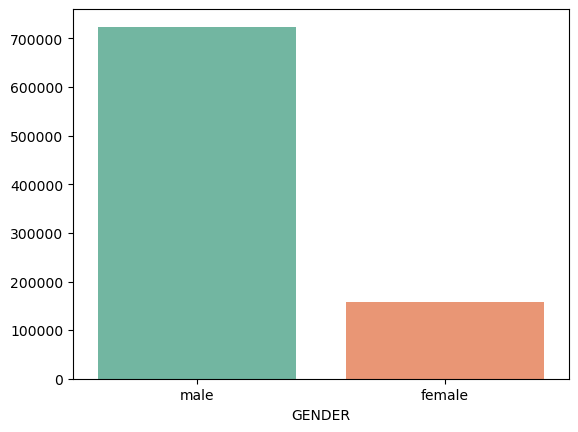

In [94]:
sns.barplot(x=frequency_GENDER.index, y=frequency_GENDER.values, hue=frequency_GENDER.index, palette="Set2")

<Axes: ylabel='count'>

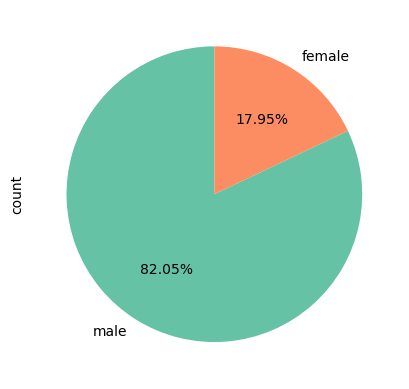

In [95]:
frequency_GENDER.plot.pie(autopct='%1.2f%%' ,startangle=90, colors=sns.color_palette('Set2'))

In [96]:
# The porportion of female representation seems much too low.
# While modern marathons having a roughly 50:50 split, earlier marathons were largely male-dominated.
# But can this explain over 4:1 ratio? Let's see.
# Can look at the gender split each year.

In [97]:
crosstab_YEAR_GENDER = pd.crosstab(index=marathon['YEAR'],
            columns=marathon['GENDER'])

In [98]:
crosstab_YEAR_GENDER

GENDER,female,male
YEAR,,
1974,10,234
1975,4,229
1976,0,311
1977,11,217
1979,15,207
1981,150,2396
1982,129,3319
1983,223,4618
1984,421,6873


In [99]:
# So here we can see that female participation numbers are missing for 1976, 1994 and 2019.
# In 1976 Ursula Blaschke was the female champion, finishing in 3:04.
# If there is a significant difference between male and female times, this absence could confuse my findings.
# So will have to drop these years.

In [100]:
marathon = marathon[(marathon['YEAR'] != 1976) & (marathon['YEAR'] != 1994) & (marathon['YEAR'] != 2019)]

In [101]:
# Let's check how that's changed the ratio

In [102]:
frequency_GENDER = marathon['GENDER'].value_counts()

<Axes: ylabel='count'>

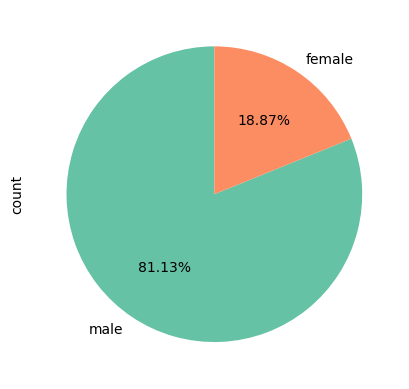

In [103]:
frequency_GENDER.plot.pie(autopct='%1.2f%%' ,startangle=90, colors=sns.color_palette('Set2'))

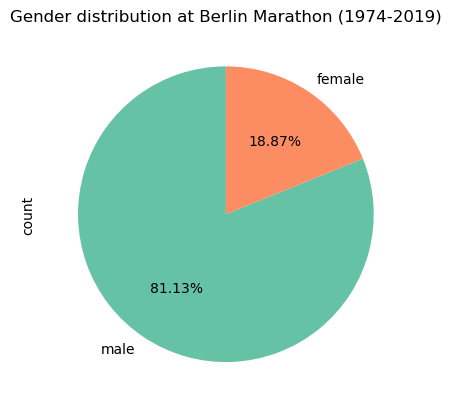

In [104]:
frequency_GENDER.plot.pie(
    autopct='%1.2f%%',
    startangle=90,
    colors=sns.color_palette('Set2')
)

plt.title("Gender distribution at Berlin Marathon (1974-2019)")
plt.show()

In [105]:
# Ever so slightly more balanced now.

In [106]:
crosstab_YEAR_GENDER = pd.crosstab(index=marathon['YEAR'],
            columns=marathon['GENDER'])

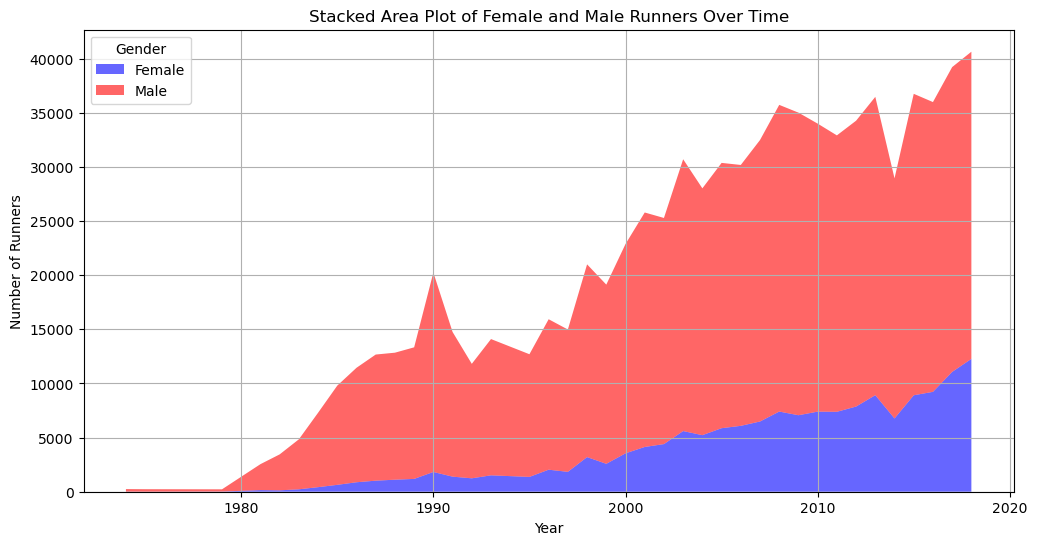

In [107]:
plt.figure(figsize=(12, 6))

plt.stackplot(crosstab_YEAR_GENDER.index, 
              crosstab_YEAR_GENDER['female'], 
              crosstab_YEAR_GENDER['male'], 
              labels=['Female', 'Male'], 
              colors=['blue', 'red'], 
              alpha=0.6)

plt.xlabel('Year')
plt.ylabel('Number of Runners')
plt.title('Stacked Area Plot of Female and Male Runners Over Time')
plt.legend(title='Gender', loc='upper left')
plt.grid(True)

plt.show()

In [108]:
# Now moving on to AGE, starting with a graph.

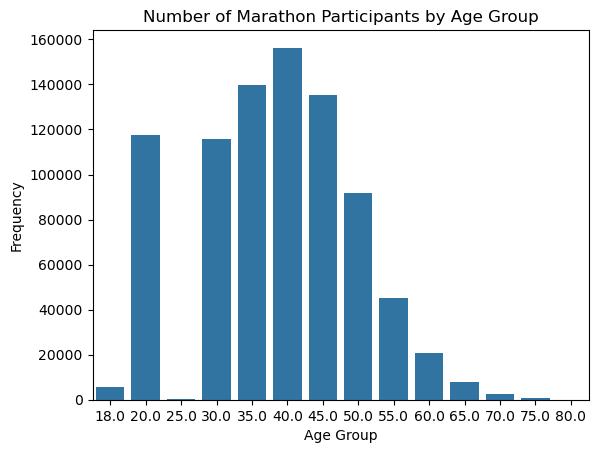

In [109]:
sns.barplot(x=marathon['AGE'].value_counts().index, y=marathon['AGE'].value_counts().values)
plt.title("Number of Marathon Participants by Age Group")
plt.xlabel("Age Group")
plt.ylabel("Frequency")
plt.show()

In [110]:
# Very strange that there is no data in the 25-30 cohort.

In [111]:
crosstab_YEAR_AGE = pd.crosstab(index=marathon['YEAR'],
           columns=marathon['AGE'])

In [112]:
crosstab_YEAR_AGE

AGE,18.0,20.0,25.0,30.0,35.0,40.0,45.0,50.0,55.0,60.0,65.0,70.0,75.0,80.0
YEAR,,,,,,,,,,,,,,
1974,0,0,50,0,79,0,50,0,17,0,8,0,0,0
1975,0,0,68,0,77,0,61,0,19,0,8,0,0,0
1977,0,126,69,0,16,0,6,0,0,0,0,0,0,0
1979,3,93,82,0,13,0,3,0,0,0,0,0,0,0
1981,100,537,0,357,413,567,308,149,69,44,0,0,0,0
1982,132,1077,0,469,554,644,350,112,60,25,14,8,0,0
1983,242,1424,0,679,708,939,548,174,81,25,13,7,0,0
1984,201,2012,0,1074,1195,1320,963,352,102,50,13,12,0,0
1985,187,2838,0,1408,1680,1555,1345,502,163,79,19,25,0,0


In [113]:
# We are just missing the data here, not totally suprising given other flaws in the dataset that I've uncovered.
# Because it is so consistent, i.e. data missing across all the years, it shouldn't distort the findings too much, just less accurate.
# Decided that i will just lump these 3 bins (18.0,	20.0, 25.0) together into a single > 30.

In [114]:
New_AGE_map = {
    18.0: '> 30.0',
    20.0: '> 30.0',
    25.0: '> 30.0'
}

marathon['AGE'] = marathon['AGE'].map(New_AGE_map).fillna(marathon['AGE'])

In [115]:
crosstab_YEAR_AGE = pd.crosstab(index=marathon['YEAR'],
           columns=marathon['AGE'])

In [116]:
# Now I will move on to TIME, which is a numerical value.
# First check which data type it is stored as.

In [117]:
marathon['AGE'].sample()

206476    50.0
Name: AGE, dtype: object

In [118]:
print(marathon.dtypes)

YEAR       int64
GENDER    object
AGE       object
TIME      object
dtype: object


In [119]:
# Right now, time is an object, so I will convert it to a float so that it's easier to work with.
# One way to do this is just convert the hours:minutes:seconds to seconds only.
# Will create a new column to store this.

In [120]:
def time_in_seconds(time_str):
    h, m, s = map(int, time_str.split(':'))
    return h * 3600 + m * 60 + s

In [121]:
marathon['TIME_(s)'] = marathon['TIME'].apply(time_in_seconds)

In [122]:
print(marathon)

        YEAR  GENDER     AGE      TIME  TIME_(s)
0       1974    male    35.0  02:44:53      9893
1       1974    male    45.0  02:46:43     10003
2       1974    male    45.0  02:48:08     10088
3       1974    male  > 30.0  02:48:40     10120
4       1974    male    35.0  02:49:01     10141
...      ...     ...     ...       ...       ...
854143  2018    male    50.0  07:21:15     26475
854144  2018    male    60.0  07:25:00     26700
854145  2018    male    60.0  07:30:15     27015
854146  2018  female    45.0  07:34:33     27273
854147  2018  female    30.0  07:40:08     27608

[839506 rows x 5 columns]


In [123]:
marathon['TIME_(s)'].describe()

count    839506.000000
mean      14516.261495
std        2541.403585
min        7299.000000
25%       12720.000000
50%       14258.000000
75%       16081.000000
max       35381.000000
Name: TIME_(s), dtype: float64

In [124]:
# Converted back to hh:mm:ss, this data reads:

# mean    04:02:15
# std     00:42:21
# min     02:01:39
# 25%     03:32:00
# 50%     03:57:38
# 75%     04:27:21
# max     09:49:21

In [125]:
# Now, let's take a look at some descriptive statistics (skewness and kurtosis) for TIME.

In [126]:
marathon['TIME_(s)'].skew().round(2)

0.5

In [127]:
# TIME_(s) (0.5): The skewness is positive, indicating that the distribution of marathon times is right-skewed. 
# Most runners completed the marathon in a similar range of times, but a few runners took significantly longer to finish.

In [128]:
marathon['TIME_(s)'].kurtosis().round(2)

0.31

In [129]:
# TIME_(s): Suggests a minority of runners with unusually long or short marathon times compared to the average.

In [130]:
# Can better visualise this distribution using a histogram.

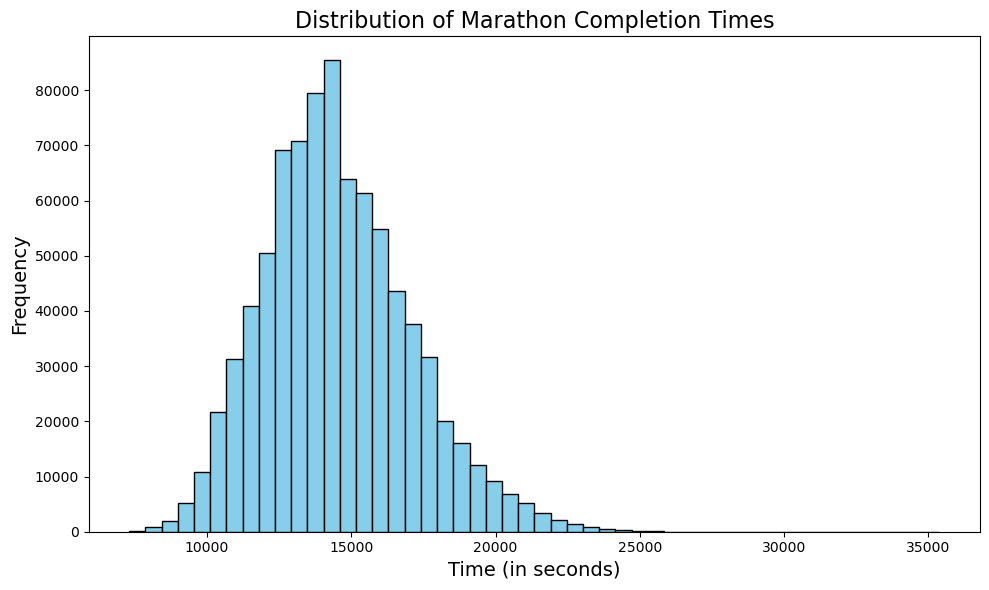

In [131]:
plt.figure(figsize=(10, 6))
plt.hist(marathon['TIME_(s)'], bins=50, color='skyblue', edgecolor='black')

plt.title("Distribution of Marathon Completion Times", fontsize=16)
plt.xlabel("Time (in seconds)", fontsize=14)
plt.ylabel("Frequency", fontsize=14)

plt.tight_layout()
plt.show()

In [132]:
# Because on the postive skew, I decided to look into these longer race times.
# Using the 'Wayback Machine', I found that there were cut-off times of 6h 15m dating back to at least 2014 (but likely much longer).
# Unfortunately, I was unable to find when cut-off times were first introduced to the Berlin Marathon.
# Decided to check whether this is reflected in the data.

In [133]:
marathon[marathon['YEAR'] == 2018]['TIME_(s)'].max()

27608

In [134]:
# 27,608 seconds converts to 7h 40m, which should be an invalid time.
# Let's see how many finish times over 6h 15m are in the dataser.

In [135]:
(marathon['TIME_(s)'] > 22500).sum()

3087

In [136]:
cutoff_crosstab = pd.crosstab(marathon['YEAR'], marathon['TIME_(s)'] > 22500)

cutoff = cutoff_crosstab[cutoff_crosstab[True] > 0][True]

cutoff

YEAR
1981      2
1985      2
1992      1
1993      1
1996      5
1997      1
1998      7
1999      2
2000     19
2002     15
2003     47
2004     42
2005     88
2006    157
2007     97
2008    108
2009    156
2010    129
2011    174
2012    126
2013    138
2014    165
2015    212
2016    345
2017    366
2018    682
Name: True, dtype: int64

In [137]:
# I will consider these values as DNFs, so will drop all of them and treat the dataset as Berlin 'Finishers' only.

In [138]:
marathon['TIME_(s)'] = marathon['TIME_(s)'].apply(lambda x: x if x <= 22500 else None)

In [139]:
marathon['TIME_(s)'].max()

22500.0

In [140]:
# How did that change the descriptive statistics?

In [141]:
marathon['TIME_(s)'].skew().round(2)

0.4

In [142]:
marathon['TIME_(s)'].kurtosis().round(2)

-0.01

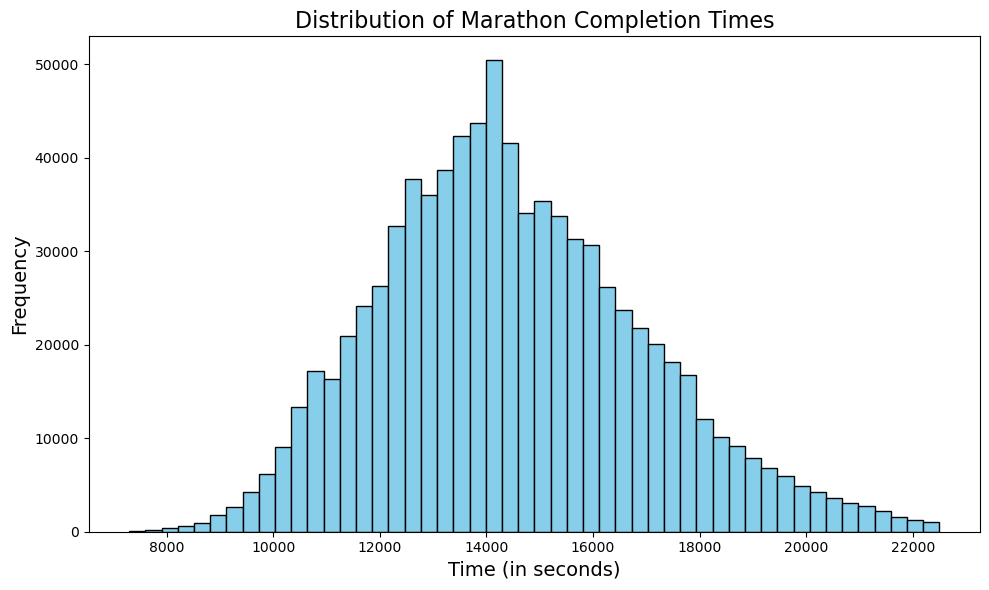

In [143]:
plt.figure(figsize=(10, 6))
plt.hist(marathon['TIME_(s)'], bins=50, color='skyblue', edgecolor='black')

plt.title("Distribution of Marathon Completion Times", fontsize=16)
plt.xlabel("Time (in seconds)", fontsize=14)
plt.ylabel("Frequency", fontsize=14)

plt.tight_layout()
plt.show()

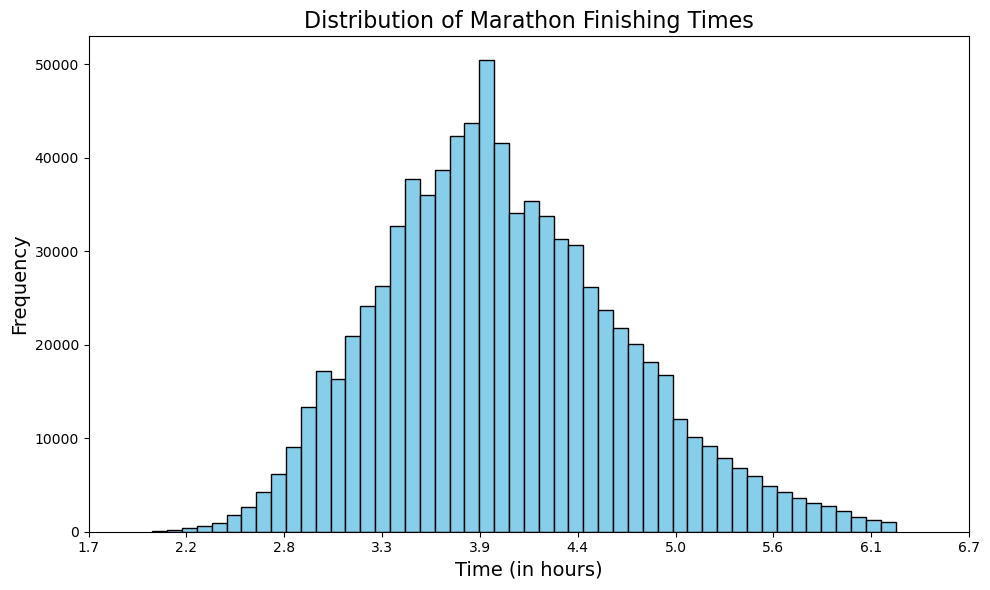

In [144]:
plt.figure(figsize=(10, 6))
plt.hist(marathon['TIME_(s)'], bins=50, color='skyblue', edgecolor='black')

plt.gca().set_xticks(plt.gca().get_xticks())
plt.gca().set_xticklabels([f"{x/3600:.1f}" for x in plt.gca().get_xticks()])

plt.title("Distribution of Marathon Finishing Times", fontsize=16)
plt.xlabel("Time (in hours)", fontsize=14)
plt.ylabel("Frequency", fontsize=14)

plt.tight_layout()
plt.show()

In [145]:
# Now I want to find the mean finish time for each year.

In [146]:
mean_finish_YEAR = marathon.groupby('YEAR')['TIME_(s)'].mean()

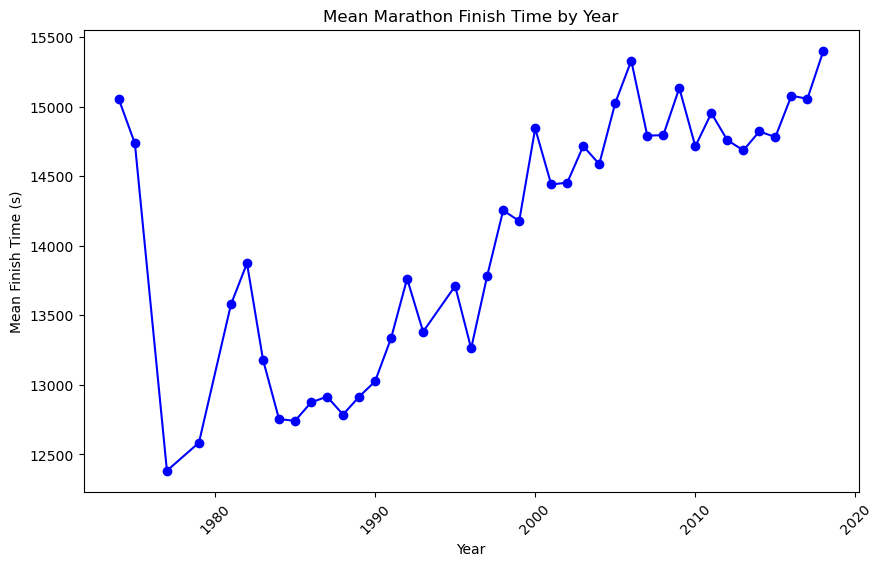

In [147]:
plt.figure(figsize=(10, 6))
plt.plot(mean_finish_YEAR.index, mean_finish_YEAR, marker='o', linestyle='-', color='b')

plt.title('Mean Marathon Finish Time by Year')
plt.xlabel('Year')
plt.ylabel('Mean Finish Time (s)')
plt.xticks(rotation=45)
plt.show()

In [148]:
# Compare male & female performance historically.

In [149]:
mean_times_GENDER = marathon.groupby(['YEAR', 'GENDER'])['TIME_(s)'].mean().unstack()

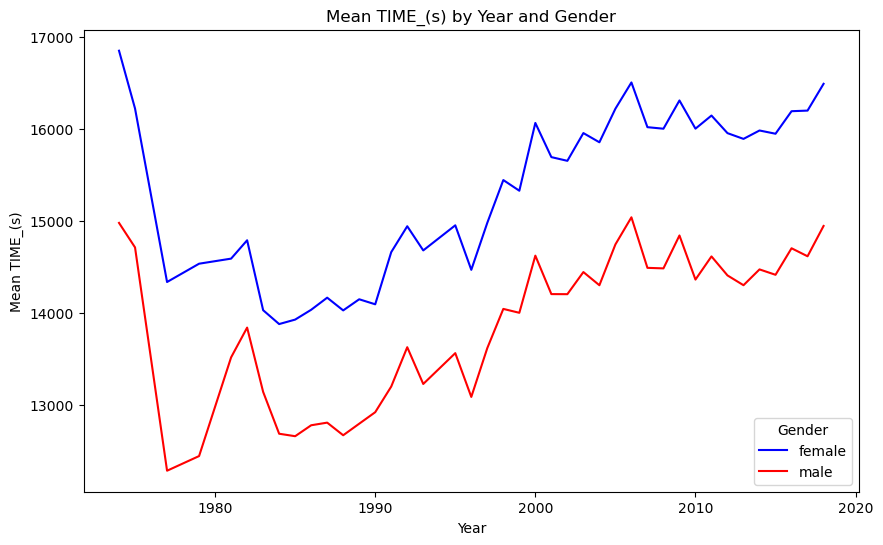

In [150]:
mean_times_GENDER.plot(kind='line', figsize=(10, 6), title="Mean TIME_(s) by Year and Gender", 
                color=['blue', 'red'])
plt.ylabel('Mean TIME_(s)')
plt.xlabel('Year')
plt.legend(title="Gender")
plt.show()

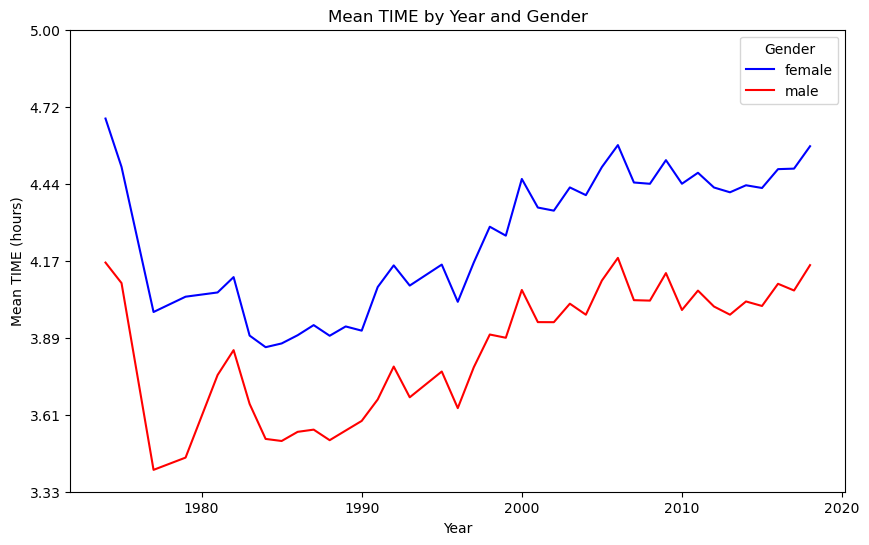

In [151]:
mean_times_GENDER.plot(kind='line', figsize=(10, 6), title="Mean TIME by Year and Gender", 
                color=['blue', 'red'])

# Update the y-axis ticks to hours
plt.gca().set_yticks(plt.gca().get_yticks())  # Get the current y-ticks
plt.gca().set_yticklabels([f"{y/3600:.2f}" for y in plt.gca().get_yticks()])

# Update labels to reflect the change
plt.ylabel('Mean TIME (hours)')
plt.xlabel('Year')
plt.legend(title="Gender")
plt.show()

In [152]:
# We can see that male average times are faster, the gap is remarkably consistent across time.

In [153]:
# My next step is to perform EDA on the weather data.

In [154]:
weather_categorical.sample(5)

,YEAR,PRECIP_CATEGORY,CLOUD_CATEGORY,TEMP_CATEGORY
3,1977,Moderate Rain,Heavy Clouds,Cold
30,2004,Light Rain,Heavy Clouds,Warm
27,2001,Light Rain,Heavy Clouds,Warm
5,1979,No Rain,Light Clouds,Cold
14,1988,Light Rain,Heavy Clouds,Warm


In [155]:
weather_categorical['PRECIP_CATEGORY'].value_counts()

PRECIP_CATEGORY
No Rain          27
Light Rain       15
Moderate Rain     1
Heavy Rain        1
Name: count, dtype: int64

In [156]:
weather_categorical['CLOUD_CATEGORY'].value_counts()

CLOUD_CATEGORY
Heavy Clouds       27
Light Clouds       13
Moderate Clouds     4
Name: count, dtype: int64

In [157]:
weather_categorical['TEMP_CATEGORY'].value_counts()

TEMP_CATEGORY
Warm    30
Hot      8
Cold     6
Name: count, dtype: int64

In [158]:
# Now to start comparing finish time with these weather conditions.

In [159]:
# First should merge the dataframes together.

In [160]:
df = pd.merge(marathon, weather_categorical, on='YEAR', how='inner')
df.head()

,YEAR,GENDER,AGE,TIME,TIME_(s),PRECIP_CATEGORY,CLOUD_CATEGORY,TEMP_CATEGORY
0,1974,male,35.0,02:44:53,9893.0,No Rain,Heavy Clouds,Cold
1,1974,male,45.0,02:46:43,10003.0,No Rain,Heavy Clouds,Cold
2,1974,male,45.0,02:48:08,10088.0,No Rain,Heavy Clouds,Cold
3,1974,male,> 30.0,02:48:40,10120.0,No Rain,Heavy Clouds,Cold
4,1974,male,35.0,02:49:01,10141.0,No Rain,Heavy Clouds,Cold


In [161]:
df.groupby('PRECIP_CATEGORY')['TIME_(s)'].mean()

PRECIP_CATEGORY
Heavy Rain       14714.791893
Light Rain       14102.243420
Moderate Rain    12382.859649
No Rain          14613.439604
Name: TIME_(s), dtype: float64

In [162]:
# Heavy Rain: 04:05:14
# Moderate Rain: 03:26:22
# Light Rain: 03:55:02
# No Rain: 04:03:33

In [163]:
df['PRECIP_CATEGORY'].value_counts()

PRECIP_CATEGORY
No Rain          586524
Light Rain       218753
Heavy Rain        34001
Moderate Rain       228
Name: count, dtype: int64

In [164]:
# Not enough data for Moderate Rain.

In [165]:
# to do - merge light + moderate

In [166]:
df.groupby('CLOUD_CATEGORY')['TIME_(s)'].mean()

CLOUD_CATEGORY
Heavy Clouds       14349.976694
Light Clouds       14689.037484
Moderate Clouds    14603.112757
Name: TIME_(s), dtype: float64

In [167]:
# Heavy Clouds: 03:59:09
# Moderate Clouds: 04:03:23
# Light Clouds: 04:04:49

In [168]:
df.groupby('TEMP_CATEGORY')['TIME_(s)'].mean()

TEMP_CATEGORY
Cold    14116.406750
Hot     14685.696329
Warm    14468.255622
Name: TIME_(s), dtype: float64

In [169]:
# Hot: 4:04:45
# Warm: 04:01:68
# Cold: 03:55:16

In [170]:
# Seems to be the clearest correlation with temperature, so will focus on this.

In [171]:
# Going to use the ANOVA test here.

In [172]:
COLD = df[df['TEMP_CATEGORY'] == 'Cold']['TIME_(s)']

In [173]:
WARM = df[df['TEMP_CATEGORY'] == 'Warm']['TIME_(s)']

In [174]:
HOT = df[df['TEMP_CATEGORY'] == 'Hot']['TIME_(s)']

In [175]:
# First need to check for any NaNs.

In [176]:
COLD.isna().sum()

139

In [177]:
WARM.isna().sum()

2524

In [178]:
HOT.isna().sum()

424

In [179]:
# Decided to drop these.

In [180]:
COLD = COLD.dropna()
WARM = WARM.dropna()
HOT = HOT.dropna()    

In [181]:
# Now to define my hypotheses:
# H₀: There is no significant difference in marathon race times between the temperature categories
# H₁: There is a significant difference in marathon race times between the temperature categories.

In [182]:
f_stat, p_value = st.f_oneway(COLD, WARM, HOT)
print(f"F-Statistic: {f_stat:.2f}")
print(f"P-Value: {p_value:.4f}")
print()

alpha = 0.05

if p_value > alpha:
    print("Fail to Reject the Null Hypothesis.")
else:
    print("Reject the Null Hypothesis.")

F-Statistic: 1259.23
P-Value: 0.0000

Reject the Null Hypothesis.


In [183]:
# F-statistic suggests a large difference between the group means relative to the variability within each group.
# Extremely low p-value indicates strong evidence against the null hypothesis

In [184]:
# Now, looking at my 'Mean Marathon Finish Time by Year' graph, I can see that times get slower over the years.
# This reflects marathon running becoming a mass participation sport.
# Elite finish times dropped markedly during this same period.
# I want to create a regression model and run the ANOVA test again, to see if the findings are replicated.
# Can see growing participation here:

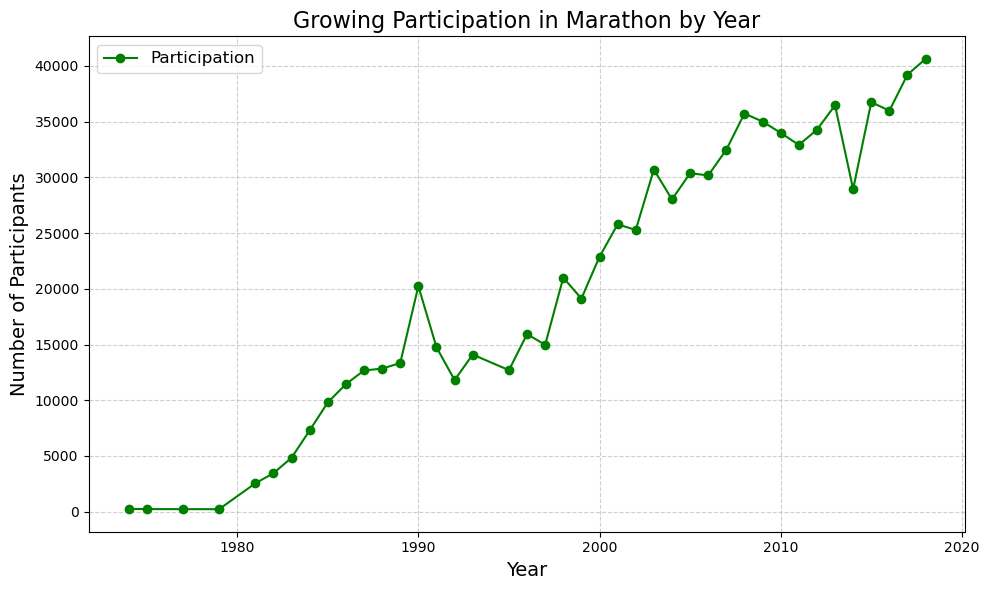

In [185]:
growing_participation = marathon.groupby('YEAR').size()

plt.figure(figsize=(10, 6))
plt.plot(growing_participation.index, growing_participation.values, marker='o', color='green', linestyle='-', label='Participation')
plt.title('Growing Participation in Marathon by Year', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of Participants', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

In [186]:
# Now a correlation coefficient test to find the relationship between participation numbers and average finishing time.

In [187]:
correlation = growing_participation.corr(mean_finish_YEAR)
correlation

0.7321515108184019

In [188]:
# A correlation of 0.73 indicates a strong positive relationship

In [189]:
mean_finish_YEAR

YEAR
1974    15052.725410
1975    14735.639485
1977    12382.859649
1979    12584.328829
1981    13578.672956
1982    13874.243329
1983    13181.544102
1984    12754.513847
1985    12741.101939
1986    12873.595388
1987    12915.768290
1988    12786.573742
1989    12914.692959
1990    13025.278080
1991    13336.133360
1992    13763.475872
1993    13382.134681
1995    13710.812047
1996    13262.005714
1997    13783.109405
1998    14254.710850
1999    14178.089821
2000    14843.554899
2001    14441.143223
2002    14453.653674
2003    14716.651295
2004    14587.795282
2005    15026.691167
2006    15330.884663
2007    14791.780975
2008    14795.425107
2009    15134.146361
2010    14714.791893
2011    14953.688668
2012    14759.034237
2013    14686.472134
2014    14821.922238
2015    14781.933773
2016    15079.022387
2017    15057.166070
2018    15402.501864
Name: TIME_(s), dtype: float64

In [190]:
# I will take from 1984 onwards, to avoid some of the inital outliers.
# Note that the course didn't run through the city proper until 1981.
# Before that was run out in the forest/countryside in Grunewald.

In [191]:
df2 = df.copy()  # Avoid modifying the original df directly
years_to_delete = [1974, 1975, 1977, 1979, 1981, 1982, 1983]
df2 = df2.loc[~df2.index.isin(years_to_delete)]  # Use .isin() to filter out rows based on the index
df2

,YEAR,GENDER,AGE,TIME,TIME_(s),PRECIP_CATEGORY,CLOUD_CATEGORY,TEMP_CATEGORY
0,1974,male,35.0,02:44:53,9893.0,No Rain,Heavy Clouds,Cold
1,1974,male,45.0,02:46:43,10003.0,No Rain,Heavy Clouds,Cold
2,1974,male,45.0,02:48:08,10088.0,No Rain,Heavy Clouds,Cold
3,1974,male,> 30.0,02:48:40,10120.0,No Rain,Heavy Clouds,Cold
4,1974,male,35.0,02:49:01,10141.0,No Rain,Heavy Clouds,Cold
...,...,...,...,...,...,...,...,...
839501,2018,male,50.0,07:21:15,NaN,No Rain,Heavy Clouds,Warm
839502,2018,male,60.0,07:25:00,NaN,No Rain,Heavy Clouds,Warm
839503,2018,male,60.0,07:30:15,NaN,No Rain,Heavy Clouds,Warm
839504,2018,female,45.0,07:34:33,NaN,No Rain,Heavy Clouds,Warm


In [192]:
years_to_delete = [1974, 1975, 1977, 1979, 1981, 1982, 1983]
df2 = df[~df['YEAR'].isin(years_to_delete)]

In [193]:
df2.head(5)

,YEAR,GENDER,AGE,TIME,TIME_(s),PRECIP_CATEGORY,CLOUD_CATEGORY,TEMP_CATEGORY
11762,1984,male,> 30.0,02:13:35,8015.0,Light Rain,Heavy Clouds,Warm
11763,1984,male,35.0,02:13:43,8023.0,Light Rain,Heavy Clouds,Warm
11764,1984,male,> 30.0,02:14:53,8093.0,Light Rain,Heavy Clouds,Warm
11765,1984,male,35.0,02:14:56,8096.0,Light Rain,Heavy Clouds,Warm
11766,1984,male,> 30.0,02:15:03,8103.0,Light Rain,Heavy Clouds,Warm


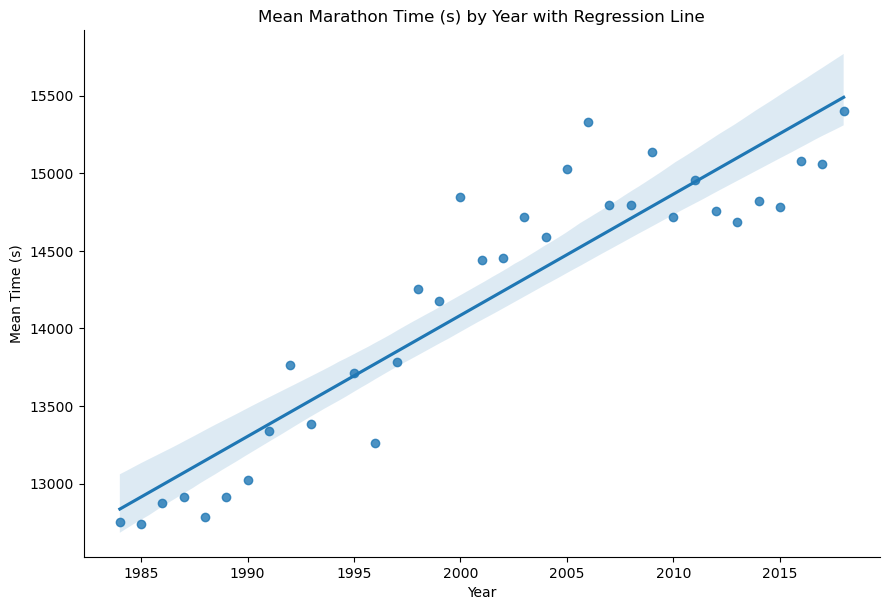

In [194]:
mean_time_by_year = df2.groupby('YEAR')['TIME_(s)'].mean().reset_index()

sns.lmplot(x='YEAR', y='TIME_(s)', data=mean_time_by_year, height=6, aspect=1.5)
plt.title('Mean Marathon Time (s) by Year with Regression Line')
plt.xlabel('Year')
plt.ylabel('Mean Time (s)')
plt.show()

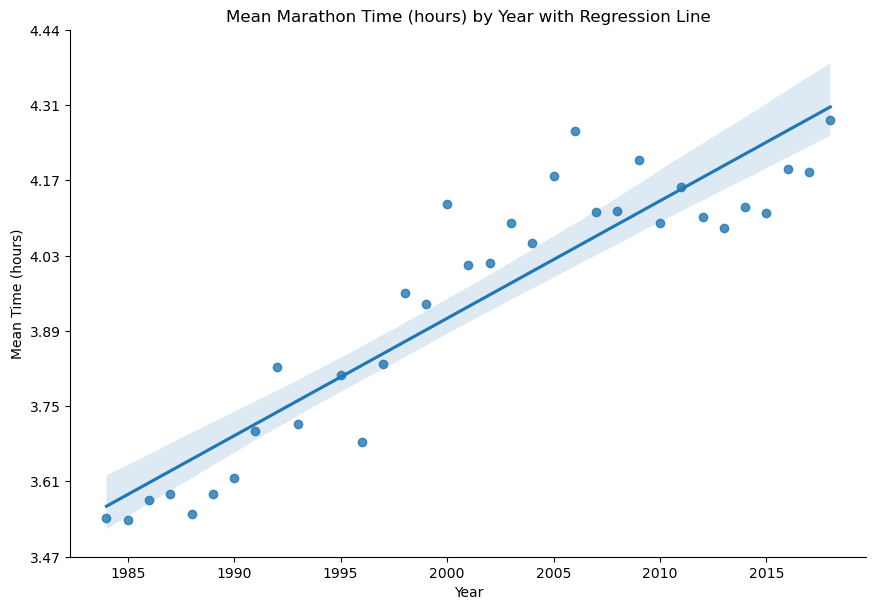

In [195]:
mean_time_by_year = df2.groupby('YEAR')['TIME_(s)'].mean().reset_index()

sns.lmplot(x='YEAR', y='TIME_(s)', data=mean_time_by_year, height=6, aspect=1.5)

plt.gca().set_yticks(plt.gca().get_yticks())
plt.gca().set_yticklabels([f"{y/3600:.2f}" for y in plt.gca().get_yticks()])

plt.title('Mean Marathon Time (hours) by Year with Regression Line')
plt.xlabel('Year')
plt.ylabel('Mean Time (hours)')

plt.show()

In [196]:
# So my plan is to find the 'residuals'.
# I.e the differences between actual and predicted values between this regression line and the actual mean finshing time.
# Then I can compare these residuals with the temperature catergories.

In [197]:
# First we need to add a column called REGRESSION.

In [198]:
coefficients = np.polyfit(mean_time_by_year['YEAR'], mean_time_by_year['TIME_(s)'], deg=1)

regression_line = np.poly1d(coefficients)

df2.loc[:, 'REGRESSION'] = regression_line(df2['YEAR'])

/var/folders/wh/mdt4h3r54f11yvfsw8xvpf040000gn/T/ipykernel_98469/1767776948.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.loc[:, 'REGRESSION'] = regression_line(df2['YEAR'])


In [199]:
df2.head(5)

,YEAR,GENDER,AGE,TIME,TIME_(s),PRECIP_CATEGORY,CLOUD_CATEGORY,TEMP_CATEGORY,REGRESSION
11762,1984,male,> 30.0,02:13:35,8015.0,Light Rain,Heavy Clouds,Warm,12835.636805
11763,1984,male,35.0,02:13:43,8023.0,Light Rain,Heavy Clouds,Warm,12835.636805
11764,1984,male,> 30.0,02:14:53,8093.0,Light Rain,Heavy Clouds,Warm,12835.636805
11765,1984,male,35.0,02:14:56,8096.0,Light Rain,Heavy Clouds,Warm,12835.636805
11766,1984,male,> 30.0,02:15:03,8103.0,Light Rain,Heavy Clouds,Warm,12835.636805


In [200]:
# Need to double check these values are correct.

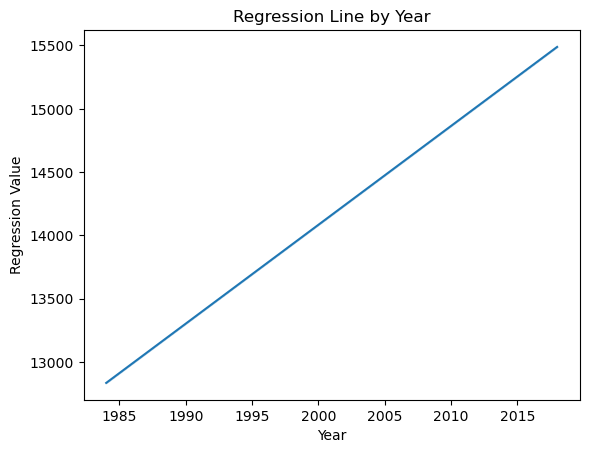

In [201]:
sns.lineplot(x=df2['YEAR'], y=df2['REGRESSION'])

plt.xlabel('Year')
plt.ylabel('Regression Value')
plt.title('Regression Line by Year')

plt.show()

In [202]:
# Now I need to calculate the RESIDUALS.

In [203]:
df2.loc[:, 'RESIDUALS'] = df2['TIME_(s)'] - df2['REGRESSION']

/var/folders/wh/mdt4h3r54f11yvfsw8xvpf040000gn/T/ipykernel_98469/3301783916.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.loc[:, 'RESIDUALS'] = df2['TIME_(s)'] - df2['REGRESSION']


In [204]:
df2.head(5)

,YEAR,GENDER,AGE,TIME,TIME_(s),PRECIP_CATEGORY,CLOUD_CATEGORY,TEMP_CATEGORY,REGRESSION,RESIDUALS
11762,1984,male,> 30.0,02:13:35,8015.0,Light Rain,Heavy Clouds,Warm,12835.636805,-4820.636805
11763,1984,male,35.0,02:13:43,8023.0,Light Rain,Heavy Clouds,Warm,12835.636805,-4812.636805
11764,1984,male,> 30.0,02:14:53,8093.0,Light Rain,Heavy Clouds,Warm,12835.636805,-4742.636805
11765,1984,male,35.0,02:14:56,8096.0,Light Rain,Heavy Clouds,Warm,12835.636805,-4739.636805
11766,1984,male,> 30.0,02:15:03,8103.0,Light Rain,Heavy Clouds,Warm,12835.636805,-4732.636805


In [205]:
df2.head(4)

,YEAR,GENDER,AGE,TIME,TIME_(s),PRECIP_CATEGORY,CLOUD_CATEGORY,TEMP_CATEGORY,REGRESSION,RESIDUALS
11762,1984,male,> 30.0,02:13:35,8015.0,Light Rain,Heavy Clouds,Warm,12835.636805,-4820.636805
11763,1984,male,35.0,02:13:43,8023.0,Light Rain,Heavy Clouds,Warm,12835.636805,-4812.636805
11764,1984,male,> 30.0,02:14:53,8093.0,Light Rain,Heavy Clouds,Warm,12835.636805,-4742.636805
11765,1984,male,35.0,02:14:56,8096.0,Light Rain,Heavy Clouds,Warm,12835.636805,-4739.636805


In [206]:
# Now I want to redo the ANOVA test.

In [207]:
COLD_2 = df2[df2['TEMP_CATEGORY'] == 'Cold']['RESIDUALS']
WARM_2 = df2[df2['TEMP_CATEGORY'] == 'Warm']['RESIDUALS']
HOT_2 = df2[df2['TEMP_CATEGORY'] == 'Hot']['RESIDUALS']

In [208]:
COLD_2 = COLD_2.dropna()
WARM_2 = WARM_2.dropna()
HOT_2 = HOT_2.dropna()    

In [209]:
f_stat, p_value = st.f_oneway(COLD_2, WARM_2, HOT_2)

print(f"F-Statistic: {f_stat:.2f}")
print(f"P-Value: {p_value:.4f}")
print()

alpha = 0.05

if p_value > alpha:
    print("Fail to Reject the Null Hypothesis.")
else:
    print("Reject the Null Hypothesis.")

F-Statistic: 3189.95
P-Value: 0.0000

Reject the Null Hypothesis.


In [210]:
# So, taking the slower times across the decades into account returned an even higher F-statistic (3189.95 vs 1259.23).
# Thus, I proved there is strong relationship between temperature and marathon finish times, meaning that temperature likely affects marathon performance.

In [211]:
# Now a bar graph to help visualise my findings.

/var/folders/wh/mdt4h3r54f11yvfsw8xvpf040000gn/T/ipykernel_98469/2938588908.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=residuals_means.index, y=residuals_means.values, palette='coolwarm')


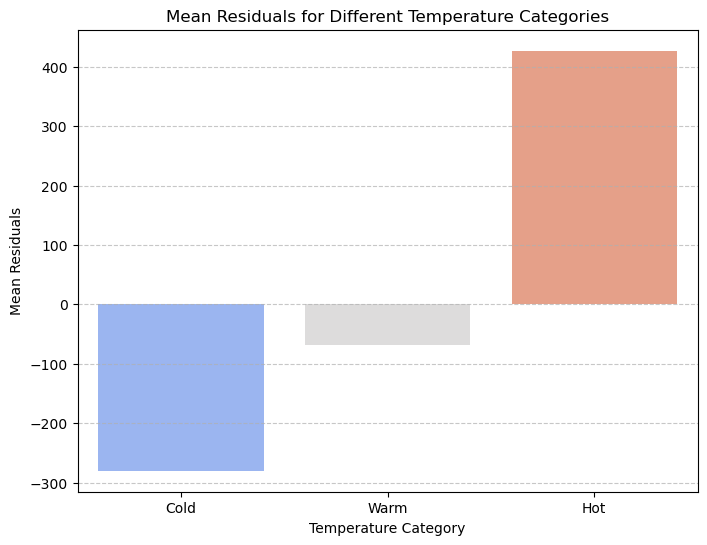

In [212]:
category_order = ['Cold', 'Warm', 'Hot']

residuals_means = df2.groupby('TEMP_CATEGORY')['RESIDUALS'].mean().reindex(category_order)

plt.figure(figsize=(8,6))
sns.barplot(x=residuals_means.index, y=residuals_means.values, palette='coolwarm')

plt.title('Mean Residuals for Different Temperature Categories')
plt.xlabel('Temperature Category')
plt.ylabel('Mean Residuals')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

plt.show()